In [120]:
import re
import ast
import itertools
from collections import Counter
import pandas as pd
import numpy as np
import scipy.sparse as sparse

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

from IPython.display import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [111]:
itemIndex = 'ItemIndex'
userIndex = 'UserIndex'
rating = 'overall'
binary = 'Binary'
keyPhrase = 'keyVector'
dataPath = 'data/baby/'
dataName = 'Data.csv'
embedding_dims = 50

In [25]:
df = pd.read_csv(dataPath+dataName)
df.head()

,Unnamed: 0,overall,unixReviewTime,vector,keyVector,UserIndex,ItemIndex,Binary
0,0,5,1373932800,"[152, 9, 204, 586, 19, 106, 185, 3, 127, 1924,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2496,0,1
1,1,5,1372464000,"[8, 834, 7, 451, 6, 572, 1189, 5, 50, 111, 18,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1343,0,1
2,2,5,1395187200,"[539, 80, 205, 619, 119, 12, 233, 212, 50, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8234,0,1
3,3,5,1376697600,"[4, 87, 8, 6, 157, 243, 9, 12, 352, 75, 2, 17,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15045,0,1
4,4,4,1396310400,"[4, 284, 85, 1524, 3, 7983, 39, 919, 7886, 612...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5810,0,1


In [97]:
num_user = df[userIndex].nunique()
num_item = df[itemIndex].nunique()
num_keyPhrases = len(ast.literal_eval(df[keyPhrase][0]))
print("Number of User: {0}".format(num_user))
print("Number of Item: {0}".format(num_item))
print("Number of key Phrase: {0}".format(num_keyPhrases))

Number of User: 19445
Number of Item: 7050
Number of key Phrase: 100


In [27]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
test_df = df[~msk]

In [93]:
def getArrays(df):
    users = df[userIndex].as_matrix()
    items = df[itemIndex].as_matrix()
    ratings = df[rating].as_matrix()
    keys = np.array(df[keyPhrase].apply(ast.literal_eval).values.tolist())
    return [users,items,ratings,keys]

train_array = getArrays(train_df)
test_array = getArrays(test_df)

In [122]:
def negative_data(df, size_per_user):

    m = df[userIndex].nunique()
    n = df[itemIndex].nunique()

    negative_data = []
    for i in range(m):
        items = np.random.choice(n, size_per_user, replace=False)
        observed_items = df[df[userIndex] == i][itemIndex].as_matrix().flatten()
        items = items[np.invert(np.isin(items, observed_items))]
        negative_data.append(sparse.csr_matrix((np.full(len(items), i), (range(len(items)), np.zeros(len(items)))),
                                               shape=(len(items), len(df.columns)))
                             + sparse.csr_matrix((items, (range(len(items)), np.ones(len(items)))),
                                                 shape=(len(items), len(df.columns))))

    return sparse.vstack(negative_data)

In [123]:
negative_data = negative_data(train_df, 10)

In [124]:
negative_data

<194268x8 sparse matrix of type '<type 'numpy.int64'>'
	with 388507 stored elements in Compressed Sparse Row format>

## Model

In [112]:
from keras.models import Model
from keras.layers import *   
from keras.backend import reshape

In [113]:
def build_model():
    userIndex = Input(shape=(1,), name='userIndex')
    itemIndex = Input(shape=(1,), name='itemIndex')

    userEmbedding = Embedding(num_user, embedding_dims, name='userEmbedding')(userIndex)
    itemEmbedding = Embedding(num_item, embedding_dims, name='itemEmbedding')(itemIndex)

    merged = concatenate([userEmbedding, itemEmbedding])
    x = Flatten()(merged)
    x = BatchNormalization()(x)
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    hidden = BatchNormalization()(x)
    pred_rating= Dense(1, activation='linear', name='rating')(hidden)
    pred_keyPhrase= Dense(num_keyPhrases, activation='sigmoid', name='keyPhrase')(hidden)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=[userIndex, itemIndex], outputs=[pred_rating, pred_keyPhrase])
    model.compile(optimizer='rmsprop',
                  loss=["mean_squared_error", "binary_crossentropy"],
                  loss_weights = [10,1],
                  metrics=['accuracy'])

    return model

model = build_model()

In [114]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
userIndex (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
itemIndex (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
userEmbedding (Embedding)       (None, 1, 50)        972250      userIndex[0][0]                  
__________________________________________________________________________________________________
itemEmbedding (Embedding)       (None, 1, 50)        352500      itemIndex[0][0]                  
__________________________________________________________________________________________________
concatenat

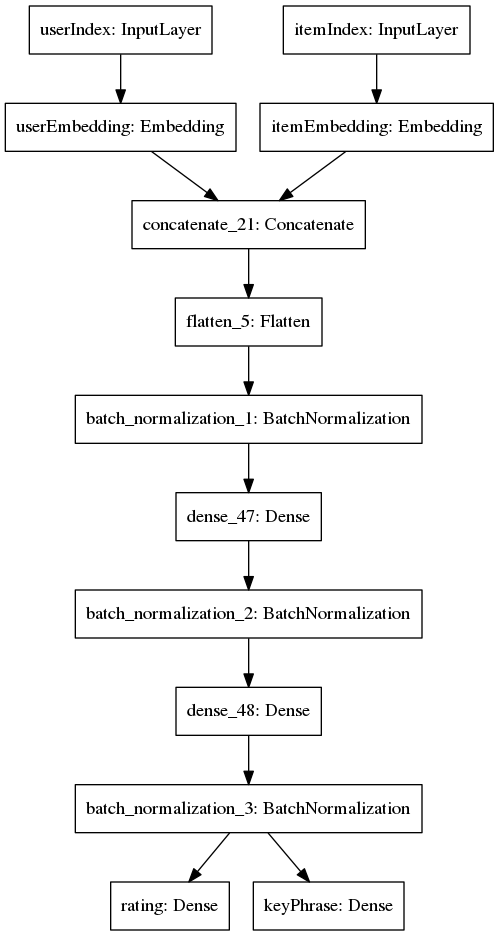

In [115]:
plot_model(model, to_file='multiple_outputs.png')
Image(filename='multiple_outputs.png') 

In [116]:
history = model.fit(train_array[:2], train_array[2:], 
                    validation_data=(test_array[:2], test_array[2:]), epochs=10, batch_size=32)

Train on 128672 samples, validate on 32120 samples
Epoch 1/10
128672/128672 [==============================] - 48s 374us/step - loss: 18.5075 - rating_loss: 1.8450 - keyPhrase_loss: 0.0574 - rating_acc: 0.2843 - keyPhrase_acc: 0.9834 - val_loss: 13.0765 - val_rating_loss: 1.3045 - val_keyPhrase_loss: 0.0312 - val_rating_acc: 0.2700 - val_keyPhrase_acc: 0.9948
Epoch 2/10
128672/128672 [==============================] - 48s 370us/step - loss: 12.0743 - rating_loss: 1.2043 - keyPhrase_loss: 0.0313 - rating_acc: 0.3419 - keyPhrase_acc: 0.9948 - val_loss: 12.6634 - val_rating_loss: 1.2632 - val_keyPhrase_loss: 0.0310 - val_rating_acc: 0.3116 - val_keyPhrase_acc: 0.9948
Epoch 3/10
128672/128672 [==============================] - 48s 370us/step - loss: 10.5630 - rating_loss: 1.0532 - keyPhrase_loss: 0.0314 - rating_acc: 0.4225 - keyPhrase_acc: 0.9948 - val_loss: 12.6297 - val_rating_loss: 1.2598 - val_keyPhrase_loss: 0.0314 - val_rating_acc: 0.3886 - val_keyPhrase_acc: 0.9948
Epoch 4/10
12867

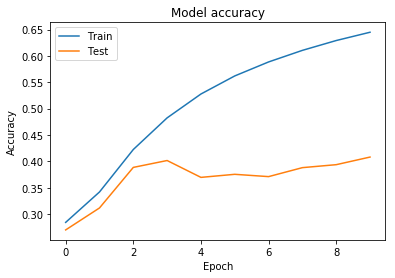

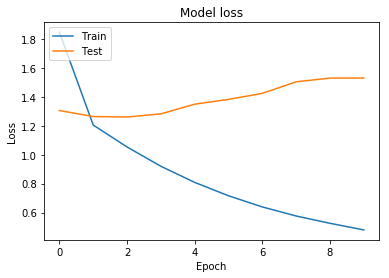

In [118]:
# Plot training & validation accuracy values
plt.plot(history.history['rating_acc'])
plt.plot(history.history['val_rating_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['rating_loss'])
plt.plot(history.history['val_rating_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

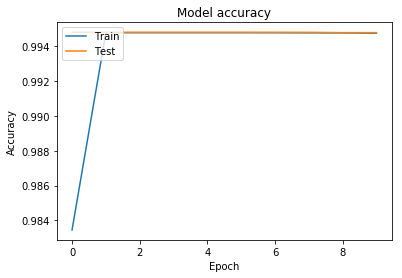

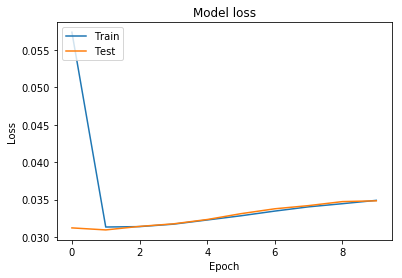

In [119]:
# Plot training & validation accuracy values
plt.plot(history.history['keyPhrase_acc'])
plt.plot(history.history['val_keyPhrase_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['keyPhrase_loss'])
plt.plot(history.history['val_keyPhrase_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()